In [63]:
import numpy as np
from time import time

import os
if 'HOSTNAME' not in os.environ:
    os.environ['HOSTNAME'] = 'ODIN' # or 'ODIN'ArithmeticError
from core.insilico_exps import ExperimentEvolution
from core.GAN_utils import upconvGAN
from core.CNN_scorers import TorchScorer
from core.Optimizers import Genetic, CholeskyCMAES

In [64]:
population_size = 40
mutation_rate = 0.25
mutation_size = 0.75
kT_multiplier = 2
n_conserve = 10
parental_skew = 0.75
optimizer = Genetic(4096, population_size, mutation_rate, mutation_size, kT_multiplier,
                    parental_skew=parental_skew, n_conserve=n_conserve)

In [65]:
# from core.GAN_utils import load_statedict_from_online
# a = load_statedict_from_online()

In [66]:
# G = upconvGAN("fc6")
# G.eval().cuda()
# G.requires_grad_(False)

In [67]:
tmpsavedir = "" # Temporary save directory

# load optimizer
optim = CholeskyCMAES(4096, population_size=40, init_sigma=2.0, Aupdate_freq=10, init_code=np.zeros([1, 4096]))
# un-comment to use our new one! 
# optim = ZOHA_Sphere_lr_euclid(4096, population_size=40, select_size=20, lr=1.5, sphere_norm=300)
# optim.lr_schedule(n_gen=75, mode="exp", lim=(50, 7.33) ,)
# explabel, model_unit = "alexnet_fc8_1", ("alexnet", ".classifier.Linear6", 1)
# explabel, model_unit = "vit_1", ("vit_b_32", ".encoder.layers.encoder_layer_11.mlp.Dropout4", 26, 0,0)
explabel, model_unit = "vit_last373", ("vit_b_32", ".heads.Linearhead", 373, 373, 373)
# .encoder.layers.encoder_layer_11.mlp.Linear3
Exp = ExperimentEvolution(model_unit, savedir=tmpsavedir, explabel=explabel, optimizer=optim, max_step=100, imgsize=(224, 224))


Space dimension: 4096, Population size: 40, Select size:20, Optimization Parameters:
Initial sigma: 2.000
cc=0.001, cs=0.050, c1=0.000 damps=1.050


synth img scores: mean -0.726 +- std 0.000
step 0  time: total 0.13s | GAN visualize 0.01s   CNN score 0.01s   optimizer step 0.11s
sigma: 1.94
synth img scores: mean -0.200 +- std 0.881
step 1  time: total 0.26s | GAN visualize 0.10s   CNN score 0.10s   optimizer step 0.05s
sigma: 1.88
synth img scores: mean -0.122 +- std 1.062
step 2  time: total 0.24s | GAN visualize 0.05s   CNN score 0.14s   optimizer step 0.04s
sigma: 1.84
synth img scores: mean 0.179 +- std 1.191
step 3  time: total 0.25s | GAN visualize 0.07s   CNN score 0.13s   optimizer step 0.06s
sigma: 1.81
synth img scores: mean 0.445 +- std 1.089
step 4  time: total 0.25s | GAN visualize 0.07s   CNN score 0.12s   optimizer step 0.06s
sigma: 1.78
synth img scores: mean 0.619 +- std 0.944
step 5  time: total 0.23s | GAN visualize 0.11s   CNN score 0.08s   optimizer step 0.04s
sigma: 1.75
synth img scores: mean 0.756 +- std 1.290
step 6  time: total 0.23s | GAN visualize 0.04s   CNN score 0.15s   optimizer step 0.04s
sigma: 1

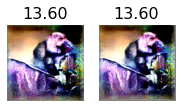

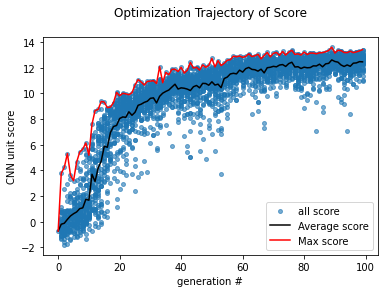

Last generation and Best code saved.


In [68]:
# run evolutions
t1 = time()
Exp.run(optim.get_init_pop())
t2 = time()
print(t2 - t1, "sec")  
Exp.visualize_best()
Exp.visualize_trajectory()
Exp.save_last_gen()

In [69]:
# print(Exp.__dict__)
model = Exp.get_model()
model

import torch
import torchvision
import torchvision.transforms as transforms

train_path = '/data/imagenet-2012/imagenet12/images/train'
transform = transforms.Compose(
    [transforms.Resize((224, 224)), 
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]
)
imagenet_data = torchvision.datasets.ImageFolder(train_path, transform=transform)
data_loader = torch.utils.data.DataLoader(
    imagenet_data,
    batch_size=256,
    shuffle=True,
    num_workers=12
)


In [70]:
scores = np.zeros(len(imagenet_data))

from tqdm import tqdm

for img_batch, i in tqdm(data_loader, total=len(data_loader)): 
    CNNmodel = Exp.CNNmodel
    with torch.no_grad():
        CNNmodel.model(img_batch.to(CNNmodel.device))
    scores[i] = CNNmodel.activation["score"].squeeze().cpu().numpy().squeeze()

np.savez(f"imagenet_scores_{explabel}.npz",scores=scores)

  2%|▏         | 84/4809 [02:19<43:30,  1.81it/s]   

(array([381.,  32.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,   1.]),
 array([1.93491578e-05, 8.37547550e-01, 1.67507575e+00, 2.51260395e+00,
        3.35013215e+00, 4.18766036e+00, 5.02518856e+00, 5.86271676e+00,
        6.70024496e+00, 7.53777316e+00, 8.37530136e+00]),
 <BarContainer object of 10 artists>)

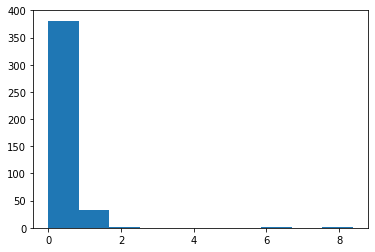

In [ ]:
import matplotlib.pyplot as plt
sc = scores[scores>0]
plt.hist(sc)


        120            Linear .encoder.layers.encoder_layer_11.mlp.Linear3
        121           Dropout .encoder.layers.encoder_layer_11.mlp.Dropout4
        122      EncoderBlock .encoder.layers.EncoderBlockencoder_layer_11
        123         LayerNorm .encoder.LayerNormln
        124           Encoder .Encoderencoder
        125            Linear .heads.Linearhead
        126      VisionTransformer .VisionTransformer